In [394]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

tickers = ["SPY", "QQQ", "IWM", "EEM"]

In [395]:
data= yf.download(tickers, start="2023-1-1", auto_adjust = False, progress=False)

In [396]:
returns = data['Adj Close'].pct_change().dropna()
print(returns.head())

Ticker           EEM       IWM       QQQ       SPY
Date                                              
2023-01-04  0.030089  0.012457  0.004764  0.007720
2023-01-05 -0.003048 -0.010709 -0.015654 -0.011413
2023-01-06  0.020892  0.022455  0.027602  0.022932
2023-01-09  0.007487  0.001689  0.006473 -0.000567
2023-01-10  0.007184  0.014785  0.008465  0.007013


In [397]:
window = 20 
ma_20 = data['Adj Close'].rolling(window = window).mean()
std_20 = data['Adj Close'].rolling(window = window).std()
z_score = (data['Adj Close'] - ma_20) / std_20

In [398]:
def z_to_signal(z):
    if pd.isna(z):
        return 0
    elif z < -1:
        return 1
    elif z > 1:
        return -1
    else: 
        return 0

signal = z_score.apply(lambda col:col.map(z_to_signal))

In [399]:
cov_window = 60
rolling_var = returns.rolling(cov_window).var()
inv_var = 1/rolling_var
weights = inv_var.div(inv_var.sum(axis=1), axis = 0)
print(weights.tail())


Ticker           EEM       IWM       QQQ       SPY
Date                                              
2025-11-11  0.216794  0.147745  0.216344  0.419117
2025-11-12  0.216275  0.146061  0.220621  0.417042
2025-11-13  0.226634  0.143373  0.221313  0.408680
2025-11-14  0.226088  0.142657  0.221553  0.409701
2025-11-17  0.222751  0.154950  0.216102  0.406197


In [400]:
common_index = signal.index.intersection(weights.index)
signal_aligned = signal.loc[common_index]
weights_aligned = weights.loc[common_index]

positions = signal_aligned * weights_aligned
print(positions.tail())
print(data['Adj Close'].tail())

Ticker           EEM       IWM       QQQ       SPY
Date                                              
2025-11-11  0.000000  0.000000  0.000000  0.000000
2025-11-12  0.000000  0.000000  0.000000  0.000000
2025-11-13  0.000000  0.143373  0.221313  0.000000
2025-11-14  0.000000  0.142657  0.221553  0.000000
2025-11-17  0.222751  0.154950  0.216102  0.406197
Ticker            EEM         IWM         QQQ         SPY
Date                                                     
2025-11-11  55.570000  244.240005  621.570007  683.000000
2025-11-12  55.580002  243.639999  621.080017  683.380005
2025-11-13  54.930000  236.789993  608.400024  672.039978
2025-11-14  54.959999  237.479996  608.859985  671.929993
2025-11-17  54.310001  232.759995  603.659973  665.669983


In [401]:
def cumulative_return(position, prices):
    common_index = position.index.intersection(prices.index)
    pos = position.loc[common_index]
    pri = prices.loc[common_index]

    dollar_change = pri.diff()
    sum_change = (dollar_change * pos.shift(1)).sum(axis=1)
    portfolio_value = 1.0 + sum_change.cumsum()
    
    # Calculate percentage change from initial value
    pct_change = ((portfolio_value / 1.0) - 1.0) * 100
    
    # Create results DataFrame
    results = pd.DataFrame({
        'portfolio_value': portfolio_value,
        'pct_change': pct_change
    })
    
    return results



'active_signals = signal_aligned.abs()\nnum_active = active_signals.sum(axis =1)\n\nvanilla_weights = active_signals.div(num_active.replace(0, 1), axis=0)\nvanilla_positions = signal_aligned * vanilla_weights\nprint(vanilla_positions.tail())'

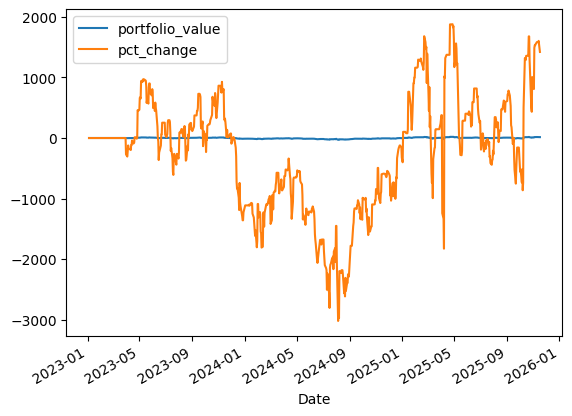

In [402]:
final = cumulative_return(positions, data['Adj Close'])
final.plot()

'''active_signals = signal_aligned.abs()
num_active = active_signals.sum(axis =1)

vanilla_weights = active_signals.div(num_active.replace(0, 1), axis=0)
vanilla_positions = signal_aligned * vanilla_weights
print(vanilla_positions.tail())'''